In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.dates as mdates
from scipy import stats

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
file_path = 'C:/Users/Lenovo/Desktop/staj_code/MSFT.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [3]:
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
close_prices_normalized = scaler.fit_transform(close_prices)

In [4]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

SEQ_LENGTH = 50

In [5]:

train_size = int(len(close_prices_normalized) * 0.8)
train_data = close_prices_normalized[:train_size]
test_data = close_prices_normalized[train_size:]

X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

In [6]:
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1
learning_rate = 0.001
batch_size = 64
num_epochs = 50

In [9]:
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = StockPriceLSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [10]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    average_epoch_loss = epoch_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_epoch_loss:.6f}')


Epoch [1/50], Average Loss: 0.000923
Epoch [2/50], Average Loss: 0.000013
Epoch [3/50], Average Loss: 0.000011
Epoch [4/50], Average Loss: 0.000013
Epoch [5/50], Average Loss: 0.000011
Epoch [6/50], Average Loss: 0.000011
Epoch [7/50], Average Loss: 0.000010
Epoch [8/50], Average Loss: 0.000013
Epoch [9/50], Average Loss: 0.000010
Epoch [10/50], Average Loss: 0.000011
Epoch [11/50], Average Loss: 0.000009
Epoch [12/50], Average Loss: 0.000009
Epoch [13/50], Average Loss: 0.000008
Epoch [14/50], Average Loss: 0.000009
Epoch [15/50], Average Loss: 0.000010
Epoch [16/50], Average Loss: 0.000008
Epoch [17/50], Average Loss: 0.000006
Epoch [18/50], Average Loss: 0.000007
Epoch [19/50], Average Loss: 0.000006
Epoch [20/50], Average Loss: 0.000008
Epoch [21/50], Average Loss: 0.000007
Epoch [22/50], Average Loss: 0.000007
Epoch [23/50], Average Loss: 0.000007
Epoch [24/50], Average Loss: 0.000006
Epoch [25/50], Average Loss: 0.000006
Epoch [26/50], Average Loss: 0.000006
Epoch [27/50], Averag

In [11]:

model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor).cpu().numpy()
    test_predictions = model(X_test_tensor).cpu().numpy()


In [12]:
# Tahminleri orijinal ölçeğe geri dönüştürme
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_orig = scaler.inverse_transform(y_train)
y_test_orig = scaler.inverse_transform(y_test)

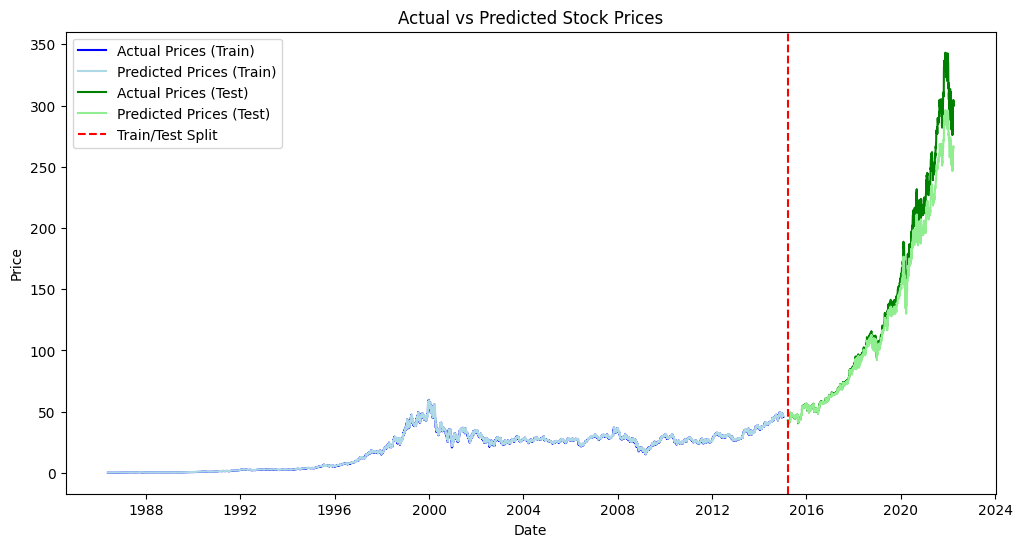

In [13]:

plt.figure(figsize=(12,6))

train_dates = data.index[SEQ_LENGTH:train_size]
test_dates = data.index[train_size+SEQ_LENGTH:]

plt.plot(train_dates, y_train_orig, label='Actual Prices (Train)', color='blue')
plt.plot(train_dates, train_predictions, label='Predicted Prices (Train)', color='lightblue')
plt.plot(test_dates, y_test_orig, label='Actual Prices (Test)', color='green')
plt.plot(test_dates, test_predictions, label='Predicted Prices (Test)', color='lightgreen')

plt.axvline(x=test_dates[0], color='r', linestyle='--', label='Train/Test Split')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()

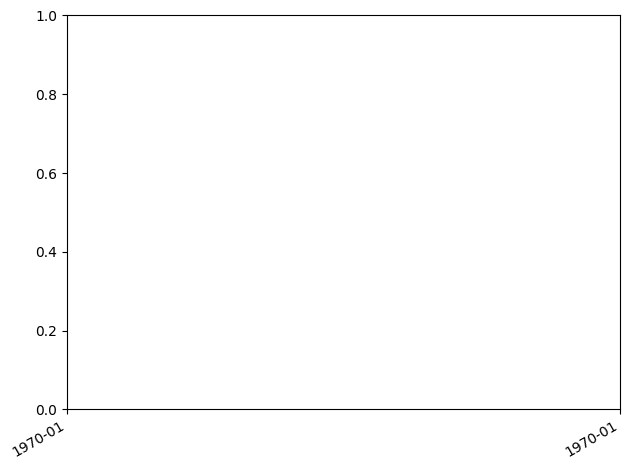

95% VaR: -0.0303
95% Expected Shortfall: -0.0466


Text(0, 0.5, 'Volatility')

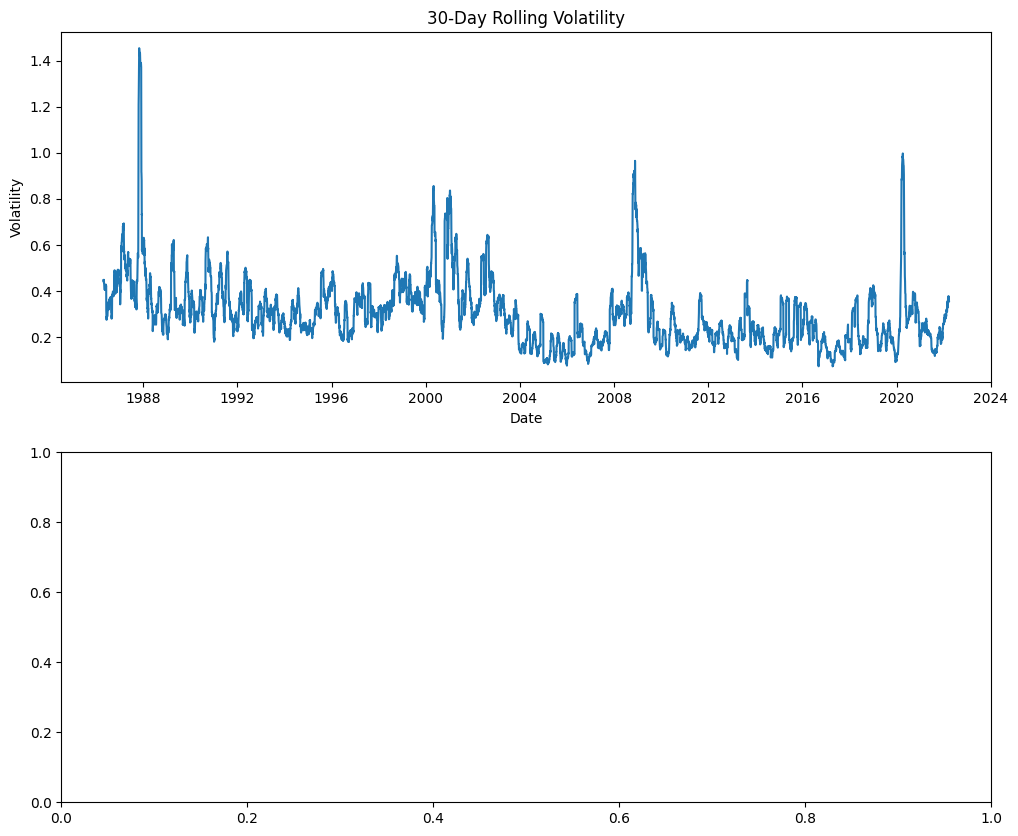

In [14]:

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Her 6 ayda bir işaret koy
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Yıl-Ay formatında göster

plt.gcf().autofmt_xdate()  # Tarih etiketlerini döndür
plt.tight_layout()
plt.show()

returns = data['Close'].pct_change().dropna()

volatility = returns.rolling(window=30).std() * np.sqrt(252)  # 252 trading days in a year

confidence_level = 0.95
VaR = np.percentile(returns, 100 * (1 - confidence_level))
ES = returns[returns <= VaR].mean()

print(f"95% VaR: {VaR:.4f}")
print(f"95% Expected Shortfall: {ES:.4f}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(volatility.index, volatility.values)
ax1.set_title('30-Day Rolling Volatility')
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility')

In [15]:

returns.hist(bins=50, ax=ax2)
ax2.axvline(VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR 95%: {VaR:.4f}')
ax2.axvline(ES, color='g', linestyle='dashed', linewidth=2, label=f'ES 95%: {ES:.4f}')
ax2.set_title('Returns Distribution with VaR and ES')
ax2.set_xlabel('Returns')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.tight_layout()
plt.show()

num_simulations = 10000
time_horizon = 30  

returns_mean = returns.mean()
returns_std = returns.std()

simulated_returns = np.random.normal(returns_mean, returns_std, (num_simulations, time_horizon))
price_paths = np.zeros((num_simulations, time_horizon + 1))
price_paths[:, 0] = close_prices[-1]

for t in range(1, time_horizon + 1):
    price_paths[:, t] = price_paths[:, t-1] * (1 + simulated_returns[:, t-1])

final_prices = price_paths[:, -1]
price_changes = (final_prices - close_prices[-1]) / close_prices[-1]

VaR_sim = np.percentile(price_changes, 100 * (1 - confidence_level))
ES_sim = price_changes[price_changes <= VaR_sim].mean()

print(f"Simulated 30-Day 95% VaR: {VaR_sim:.4f}")
print(f"Simulated 30-Day 95% Expected Shortfall: {ES_sim:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(price_changes, bins=50, edgecolor='black')
plt.axvline(VaR_sim, color='r', linestyle='dashed', linewidth=2, label=f'VaR 95%: {VaR_sim:.4f}')
plt.axvline(ES_sim, color='g', linestyle='dashed', linewidth=2, label=f'ES 95%: {ES_sim:.4f}')
plt.title('Simulated 30-Day Price Change Distribution')
plt.xlabel('Price Change %')
plt.ylabel('Frequency')
plt.legend()
plt.show()

AssertionError: passed axis not bound to passed figure

<Figure size 640x480 with 0 Axes>